# This research focuses on accurate forecasting of sales from a truck dealership. The data presented ranges from January 1st 2003, until December 1st 2014. 

## First we need to import the data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.api import Holt, ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import holtwinters

In [3]:
df = pd.DataFrame(pd.read_csv(r"C:\Users\austi\Downloads\Truck_Sales_Time_Series\Truck_sales.csv"))
df.tail()

,Month-Year,Number_Trucks_Sold
139,14-Aug,933
140,14-Sep,704
141,14-Oct,639
142,14-Nov,571
143,14-Dec,666


In [4]:
df.shape

(144, 2)

## Adding columns to better represent the time of data 

In [5]:
date_range = pd.date_range(start = '2003/01/01', end = '2014/12/31', freq = 'MS')
date_range

DatetimeIndex(['2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01',
               ...
               '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01',
               '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01',
               '2014-11-01', '2014-12-01'],
              dtype='datetime64[ns]', length=144, freq='MS')

In [6]:
df.index = date_range
df['Year'] = date_range.year
df['Month'] = date_range.month_name()
df.drop('Month-Year', axis=1, inplace= True)
df

,Number_Trucks_Sold,Year,Month
2003-01-01,155,2003,January
2003-02-01,173,2003,February
2003-03-01,204,2003,March
2003-04-01,219,2003,April
2003-05-01,223,2003,May
...,...,...,...
2014-08-01,933,2014,August
2014-09-01,704,2014,September
2014-10-01,639,2014,October
2014-11-01,571,2014,November


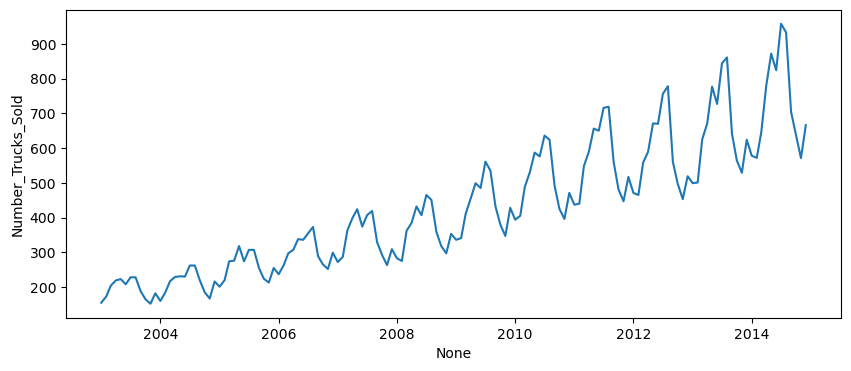

In [7]:
plt.figure(figsize=(10,4))
sns.lineplot(data=df, x=df.index, y='Number_Trucks_Sold')
plt.show()

## Pivot Tables to better show the best times for sales by month and year

In [8]:
month_pivot = pd.pivot(data=df, values = 'Number_Trucks_Sold', index='Month', columns='Year')
month_pivot = month_pivot.reindex(index=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September','October','November', 'December'])
month_pivot

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Month,,,,,,,,,,,,
January,155,160,201,237,272,283,336,394,437,471,499,578
February,173,185,220,263,287,275,341,405,440,465,501,572
March,204,217,274,297,363,362,411,488,548,558,625,646
April,219,229,276,307,398,385,455,530,590,590,671,781
May,223,231,318,338,424,432,499,587,656,671,777,872
June,208,230,274,336,374,407,485,576,650,670,727,824
July,228,262,307,354,407,465,561,636,716,756,844,958
August,228,262,307,373,419,451,535,624,719,778,861,933
September,188,219,255,289,329,359,432,492,560,560,641,704


In [15]:
month_pivot.style.apply(highlight_max,axis=1)

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Month,,,,,,,,,,,,
January,155,160,201,237,272,283,336,394,437,471,499,578
February,173,185,220,263,287,275,341,405,440,465,501,572
March,204,217,274,297,363,362,411,488,548,558,625,646
April,219,229,276,307,398,385,455,530,590,590,671,781
May,223,231,318,338,424,432,499,587,656,671,777,872
June,208,230,274,336,374,407,485,576,650,670,727,824
July,228,262,307,354,407,465,561,636,716,756,844,958
August,228,262,307,373,419,451,535,624,719,778,861,933
September,188,219,255,289,329,359,432,492,560,560,641,704


In [10]:
year_pivot = month_pivot.T
year_pivot

Month,January,February,March,April,May,June,July,August,September,October,November,December
Year,,,,,,,,,,,,
2003,155,173,204,219,223,208,228,228,188,165,152,182
2004,160,185,217,229,231,230,262,262,219,185,167,216
2005,201,220,274,276,318,274,307,307,255,224,213,255
2006,237,263,297,307,338,336,354,373,289,265,252,299
2007,272,287,363,398,424,374,407,419,329,293,263,309
2008,283,275,362,385,432,407,465,451,359,318,297,353
2009,336,341,411,455,499,485,561,535,432,380,347,428
2010,394,405,488,530,587,576,636,624,492,425,396,471
2011,437,440,548,590,656,650,716,719,560,481,447,517


In [11]:
def highlight_max(i):
    is_max = i==i.max()
    return ['background-color: green' if v else '' for v in is_max]
year_pivot.style.apply(highlight_max,axis=1)

Month,January,February,March,April,May,June,July,August,September,October,November,December
Year,,,,,,,,,,,,
2003,155,173,204,219,223,208,228,228,188,165,152,182
2004,160,185,217,229,231,230,262,262,219,185,167,216
2005,201,220,274,276,318,274,307,307,255,224,213,255
2006,237,263,297,307,338,336,354,373,289,265,252,299
2007,272,287,363,398,424,374,407,419,329,293,263,309
2008,283,275,362,385,432,407,465,451,359,318,297,353
2009,336,341,411,455,499,485,561,535,432,380,347,428
2010,394,405,488,530,587,576,636,624,492,425,396,471
2011,437,440,548,590,656,650,716,719,560,481,447,517


<Axes: >

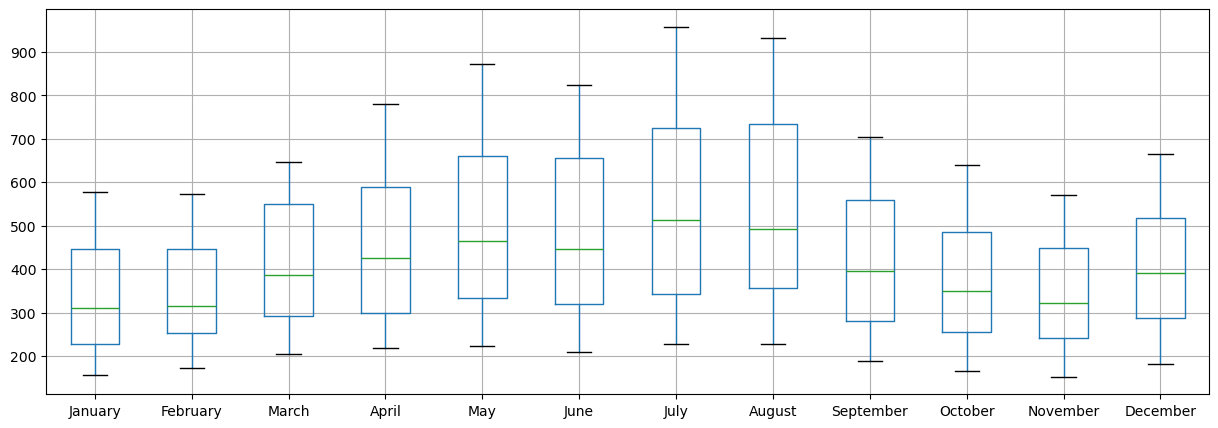

In [13]:
plt.figure(figsize=(15,5))
year_pivot.boxplot()

<Axes: >

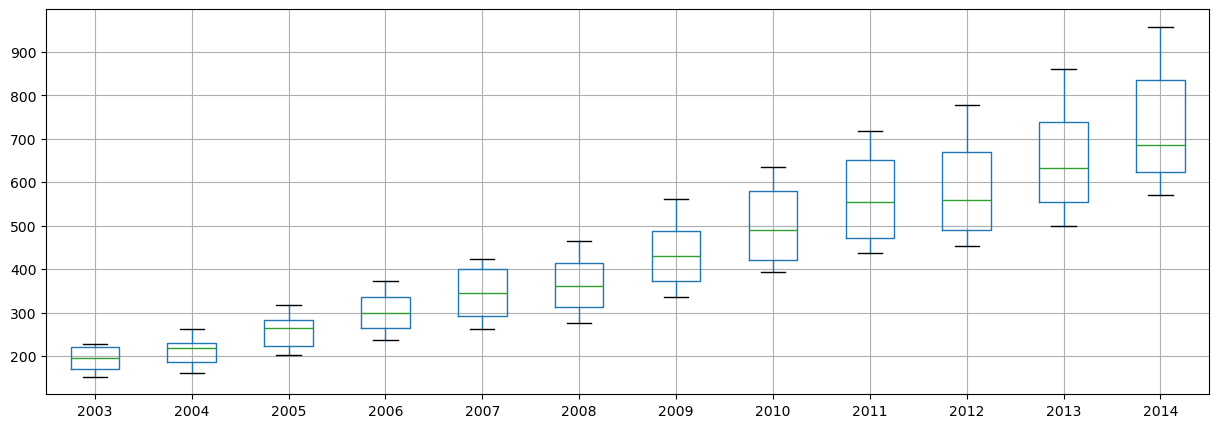

In [16]:
plt.figure(figsize=(15,5))
month_pivot.boxplot()

## Prep the Data for forecasting 

### Data Stationarity

In [17]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df['Number_Trucks_Sold']) #python implementation of dicky fuller test
dftest

(1.1158932574252765,
 0.9953500083802602,
 14,
 129,
 {'1%': -3.482087964046026,
  '5%': -2.8842185101614626,
  '10%': -2.578864381347275},
 1107.5217075915425)

In [18]:
print('The test stat is:', dftest[0], '\nThe P-Value is: ', dftest[1], '\n\nThe data is NOT stationary')

The test stat is: 1.1158932574252765 
The P-Value is:  0.9953500083802602 

The data is NOT stationary


Text(0, 0.5, 'Truck Sales')

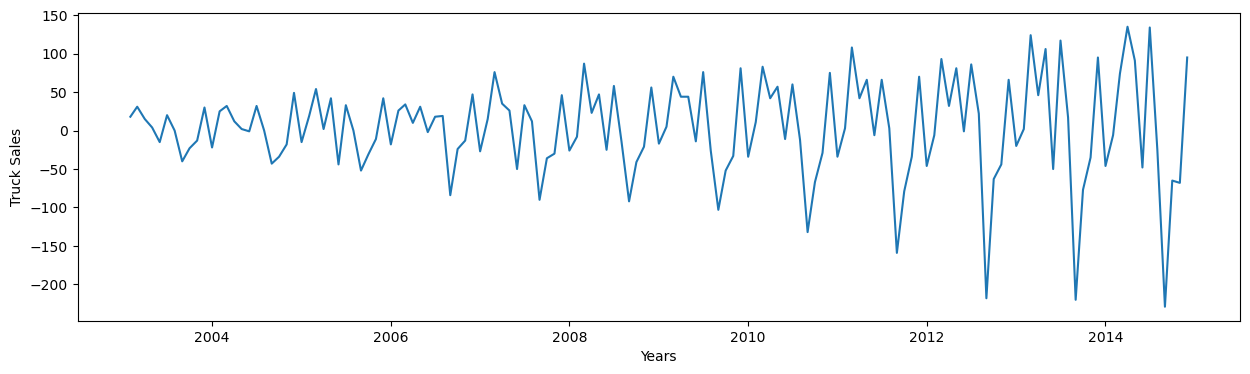

In [19]:
plt.figure(figsize=(15, 4))
plt.plot(df['Number_Trucks_Sold'].diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Truck Sales')

Text(0, 0.5, 'Truck Sales')

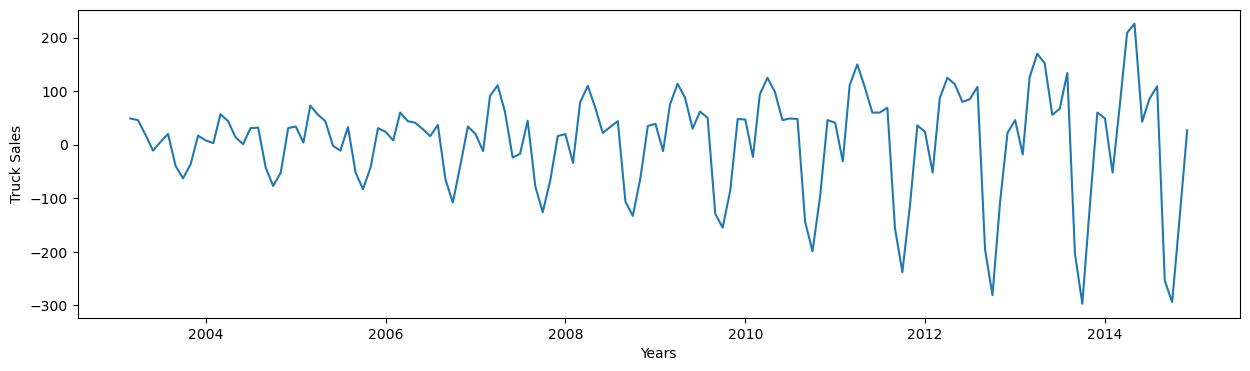

In [20]:
plt.figure(figsize=(15, 4))
plt.plot(df['Number_Trucks_Sold'].diff(periods=2))
plt.xlabel('Years')
plt.ylabel('Truck Sales')

Text(0, 0.5, 'Truck Sales')

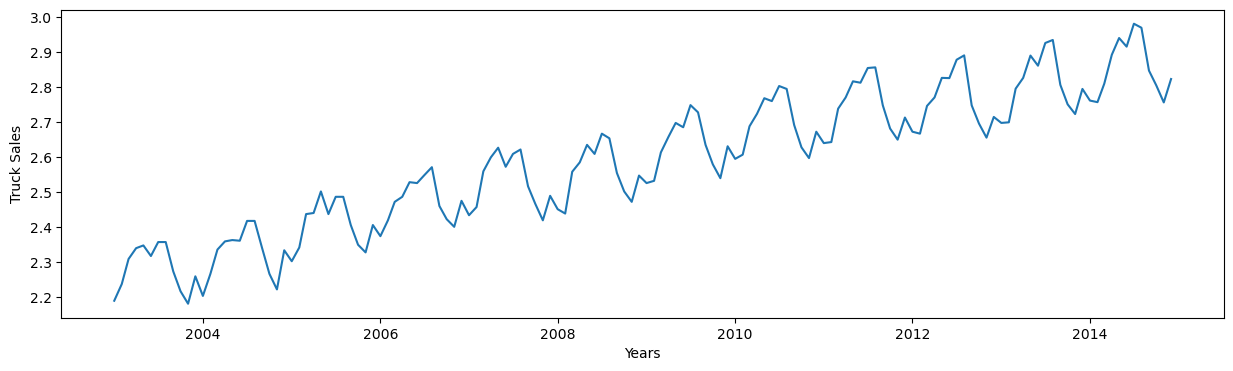

In [21]:
plt.figure(figsize=(15, 4))
plt.plot(np.log10(df['Number_Trucks_Sold']))
plt.xlabel('Years')
plt.ylabel('Truck Sales')

Text(0, 0.5, 'Truck Sales')

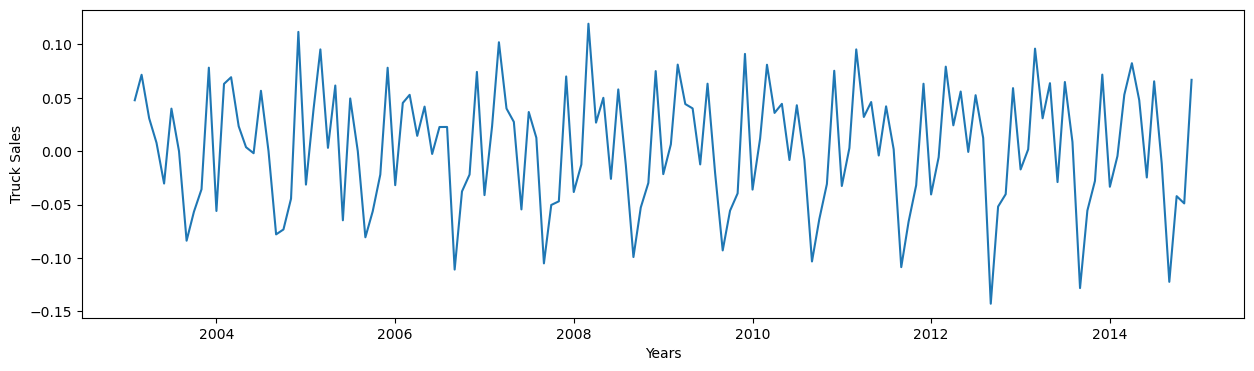

In [22]:
plt.figure(figsize=(15, 4))
plt.plot(np.log10(df['Number_Trucks_Sold']).diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Truck Sales')

Text(0, 0.5, 'Truck Sales')

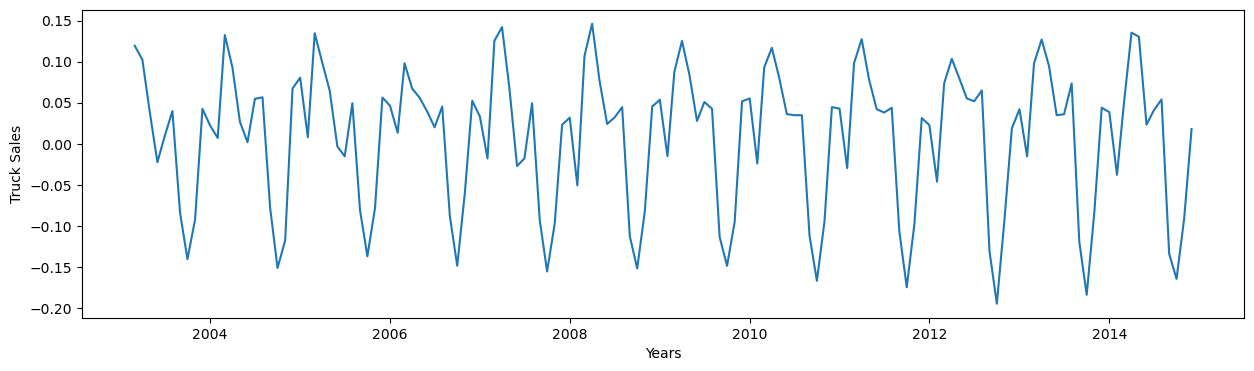

In [23]:
plt.figure(figsize=(15, 4))
plt.plot(np.log10(df['Number_Trucks_Sold']).diff(periods=2))
plt.xlabel('Years')
plt.ylabel('Truck Sales')

In [24]:
df_test = adfuller(np.log10(df['Number_Trucks_Sold']).diff(periods=2).dropna())

print('The test stat is:', df_test[0], '\nThe P-Value is: ', df_test[1], '\n\nThe data is NOW stationary')

The test stat is: -3.2107118233693535 
The P-Value is:  0.01937294947942287 

The data is NOW stationary


### Seperate to training and test sets

In [25]:
df['Month'] = date_range.month.astype('int')

train = df.loc[df.index < '2013/01/01']
test = df.loc[df.index >= '2013/01/01']

df_test2 = adfuller(train['Number_Trucks_Sold'])
print(df_test2, '\nThe training data is not stationary yet')

(-0.48392686151528475, 0.8951150805810408, 13, 106, {'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10%': -2.58153320754717}, 882.1447697925688) 
The training data is not stationary yet


In [26]:
train_log = np.log10(train['Number_Trucks_Sold'])
df_test2 = adfuller(train_log)
print(df_test2, 'The training data is now fully statinoary')

(-1.870195649495359, 0.3462092546064356, 13, 106, {'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10%': -2.58153320754717}, -536.2677333089349) The training data is now fully statinoary


## Finding the best forecast model

#### ARIMA/SARIMA prep

In [27]:
p = range(1,4)
d = range(0,2)
q = range(1,4)

pdq_ar_model = list(itertools.product(p, range(1), range(1)))


pdq_arma_model = list(itertools.product(p, range(1), q))

pdq = list(itertools.product(p,d,q))


pdq_seasonal = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]


In [28]:
pdq_ar_model

[(1, 0, 0), (2, 0, 0), (3, 0, 0)]

In [29]:
pdq_arma_model

[(1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3)]

In [30]:
pdq

[(1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3)]

In [31]:
pdq_seasonal

[(1, 0, 1, 12),
 (1, 0, 2, 12),
 (1, 0, 3, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 1, 3, 12),
 (2, 0, 1, 12),
 (2, 0, 2, 12),
 (2, 0, 3, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12),
 (2, 1, 3, 12),
 (3, 0, 1, 12),
 (3, 0, 2, 12),
 (3, 0, 3, 12),
 (3, 1, 1, 12),
 (3, 1, 2, 12),
 (3, 1, 3, 12)]

In [32]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

In [33]:
ar_aic = pd.DataFrame(columns = ['param', 'AIC'])

for param in pdq_ar_model:
    arima_model = ARIMA(train_log, order = param).fit()
    print('ARIMA{} - AIC{}'.format(param, arima_model.aic))
    row={'param': param, 'AIC': arima_model.aic}
    ar_aic = pd.concat([pd.DataFrame([row])], ignore_index=True)


ARIMA(1, 0, 0) - AIC-345.8632381461482
ARIMA(2, 0, 0) - AIC-346.480980497563
ARIMA(3, 0, 0) - AIC-344.48666318155557


In [34]:
best_ar_model = ARIMA(train_log, order=(2,0,0))
best_ar_results = best_ar_model.fit()
print(best_ar_results.summary().tables[0])
print(best_ar_results.summary().tables[1])

                               SARIMAX Results                                
Dep. Variable:     Number_Trucks_Sold   No. Observations:                  120
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 177.240
Date:                Wed, 11 Jun 2025   AIC                           -346.481
Time:                        17:56:25   BIC                           -335.331
Sample:                    01-01-2003   HQIC                          -341.953
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5223      0.079     31.898      0.000       2.367       2.677
ar.L1          1.0998      0.126      8.721      0.000       0.853       1.347
ar.L2         -0.1491      0.126     -1.185      0.2

In [35]:
pred_dynamic = best_ar_results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=True)
pred99 = best_ar_results.get_forecast(steps = len(test))
ar_forecast = pred_dynamic.predicted_mean

test_copy = test.copy()

test_copy['forecast'] = (np.power(10, pred99.predicted_mean))

mse = ((test_copy['Number_Trucks_Sold']-test_copy['forecast'])**2).mean()
rmse = np.sqrt(mse)
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 3)))

The Root Mean Squared Error of our forecasts is 306.142


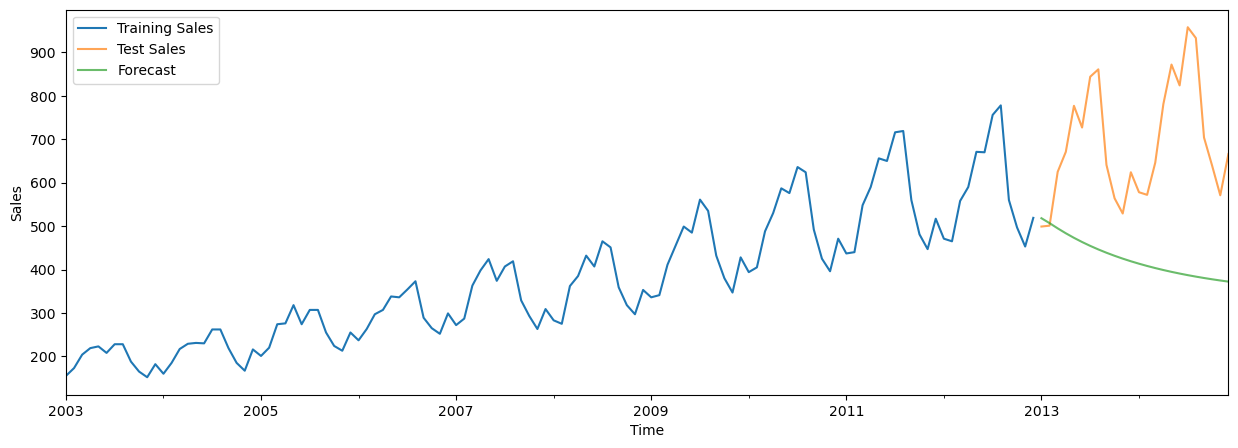

In [36]:
axis = train['Number_Trucks_Sold'].plot(label = 'Training Sales', figsize = (15,5))
test_copy['Number_Trucks_Sold'].plot(ax=axis, label='Test Sales', alpha=0.7)
test_copy['forecast'].plot(ax=axis, label = 'Forecast', alpha=0.7)

axis.set_xlabel('Time')
axis.set_ylabel('Sales')
plt.legend(loc='best')
plt.show()
plt.close()

In [37]:
results_1 = pd.DataFrame({'RMSE': rmse}, index = ['Best AR model: (1,0,0)'])
results_1

,RMSE
"Best AR model: (1,0,0)",306.142152


#### ARMA Model

In [38]:
arma_aic = pd.DataFrame(columns = ['param', 'aic'])
arma_aic

,param,aic


In [39]:
for param in pdq_arma_model:
    arma_model = ARIMA(train_log, order=param).fit()
    print('ARMA {} - AIC {}'.format(param, arma_model.aic))
    row={'param': param, 'aic':arma_model.aic}
    arma_aic = pd.concat([arma_aic, pd.DataFrame([row])], ignore_index = True)

ARMA (1, 0, 1) - AIC -346.4412586467316
ARMA (1, 0, 2) - AIC -344.4999386905594


C:\Users\austi\AppData\Local\Temp\ipykernel_11840\3002684386.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  arma_aic = pd.concat([arma_aic, pd.DataFrame([row])], ignore_index = True)
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA (1, 0, 3) - AIC -354.4424685587556
ARMA (2, 0, 1) - AIC -344.4854973044145
ARMA (2, 0, 2) - AIC -347.2827213576734


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA (2, 0, 3) - AIC -353.6786234322081
ARMA (3, 0, 1) - AIC -347.0009779267911


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA (3, 0, 2) - AIC -345.32115380485993
ARMA (3, 0, 3) - AIC -373.65637302975284


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [40]:
arma_aic.sort_values(by='aic', ascending=True).head()

,param,aic
8,"(3, 0, 3)",-373.656373
2,"(1, 0, 3)",-354.442469
5,"(2, 0, 3)",-353.678623
4,"(2, 0, 2)",-347.282721
6,"(3, 0, 1)",-347.000978


In [41]:
arma_model = ARIMA(train_log, order = (3,0,3))
arma_results = arma_model.fit()
print(arma_results.summary().tables[0])
print(arma_results.summary().tables[1])

C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:     Number_Trucks_Sold   No. Observations:                  120
Model:                 ARIMA(3, 0, 3)   Log Likelihood                 194.828
Date:                Wed, 11 Jun 2025   AIC                           -373.656
Time:                        17:56:27   BIC                           -351.356
Sample:                    01-01-2003   HQIC                          -364.600
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5251      1.324      1.907      0.057      -0.071       5.121
ar.L1         -0.6234      0.067     -9.370      0.000      -0.754      -0.493
ar.L2          0.6907      0.047     14.657      0.0

C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
arma_pred_dynamic = arma_results.get_prediction(start = pd.to_datetime('2012-01-01'), dynamic=True)
arma_pred_99 = arma_results.get_forecast(steps=len(test))

arma_forecast = arma_pred_dynamic.predicted_mean
test_copy['arma_forecast'] = np.power(10, arma_pred_99.predicted_mean)

arma_mse = ((test_copy['Number_Trucks_Sold'] - test_copy['arma_forecast']) **2).mean()
arma_rmse = np.sqrt(arma_mse)

print('The Root Mean Squared Error of our forecasts is {}'.format(round(arma_rmse, 3)))

The Root Mean Squared Error of our forecasts is 232.039


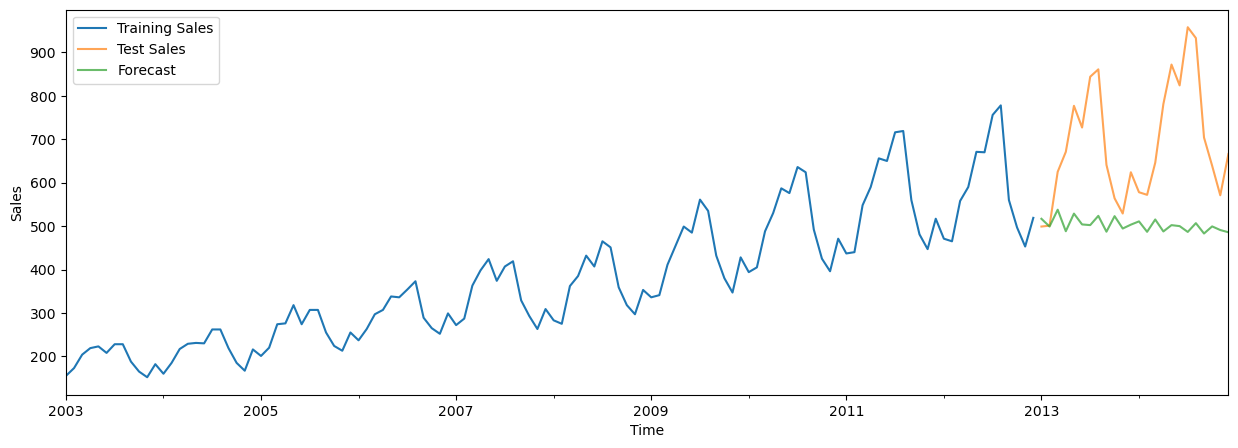

In [43]:
axis = train['Number_Trucks_Sold'].plot(label = 'Training Sales', figsize = (15,5))
test_copy['Number_Trucks_Sold'].plot(ax=axis, label='Test Sales', alpha=0.7)
test_copy['arma_forecast'].plot(ax=axis, label = 'Forecast', alpha=0.7)

axis.set_xlabel('Time')
axis.set_ylabel('Sales')
plt.legend(loc='best')
plt.show()
plt.close()

In [44]:
results_2 = pd.DataFrame({"RMSE": arma_rmse}, index= ['Best ARMA model: (3,0,3)'])
pd.concat([results_1, results_2])

,RMSE
"Best AR model: (1,0,0)",306.142152
"Best ARMA model: (3,0,3)",232.039027


#### ARIMA Model

In [45]:
arima_aic = pd.DataFrame(columns =['param','aic'])
arima_aic

,param,aic


In [46]:
for param in pdq:
    arima_model = ARIMA(train_log, order=param).fit()
    print('ARIMA {} - AIC {}'.format(param, arima_model.aic))
    row = {'param':param, 'aic':arima_model.aic}
    arima_aic = pd.concat([arima_aic, pd.DataFrame([row])], ignore_index=True)

ARIMA (1, 0, 1) - AIC -346.4412586467316
ARIMA (1, 0, 2) - AIC -344.4999386905594


C:\Users\austi\AppData\Local\Temp\ipykernel_11840\2118519491.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  arima_aic = pd.concat([arima_aic, pd.DataFrame([row])], ignore_index=True)
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: 

ARIMA (1, 0, 3) - AIC -354.4424685587556
ARIMA (1, 1, 1) - AIC -345.29068599553324
ARIMA (1, 1, 2) - AIC -343.30244877512393
ARIMA (1, 1, 3) - AIC -357.34927829324465
ARIMA (2, 0, 1) - AIC -344.4854973044145
ARIMA (2, 0, 2) - AIC -347.2827213576734


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 3) - AIC -353.6786234322081
ARIMA (2, 1, 1) - AIC -353.370646981933


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\austi\anaconda3\Lib\s

ARIMA (2, 1, 2) - AIC -372.9365843202147
ARIMA (2, 1, 3) - AIC -355.41139273217794


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA (3, 0, 1) - AIC -347.0009779267911
ARIMA (3, 0, 2) - AIC -345.32115380485993


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (3, 0, 3) - AIC -373.65637302975284
ARIMA (3, 1, 1) - AIC -341.5811054692706
ARIMA (3, 1, 2) - AIC -358.5128288529356
ARIMA (3, 1, 3) - AIC -373.23685794619723


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [47]:
arima_aic.sort_values(by='aic', ascending = True).head()

,param,aic
14,"(3, 0, 3)",-373.656373
17,"(3, 1, 3)",-373.236858
10,"(2, 1, 2)",-372.936584
16,"(3, 1, 2)",-358.512829
5,"(1, 1, 3)",-357.349278


In [48]:
best_arima = ARIMA(train_log, order = (3,1,3))
best_arima_results = best_arima.fit()

print(best_arima_results.summary().tables[0])
print(best_arima_results.summary().tables[1])

                               SARIMAX Results                                
Dep. Variable:     Number_Trucks_Sold   No. Observations:                  120
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 193.618
Date:                Wed, 11 Jun 2025   AIC                           -373.237
Time:                        17:56:30   BIC                           -353.783
Sample:                    01-01-2003   HQIC                          -365.337
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7503      0.171      4.399      0.000       0.416       1.085
ar.L2         -0.7856      0.070    -11.179      0.000      -0.923      -0.648
ar.L3          0.6816      0.139      4.913      0.0

C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [49]:
arima_pred_dynamic = best_arima_results.get_prediction(start = pd.to_datetime('2012-01-01'), dynamic = True)
arima_pred_99 = best_arima_results.get_forecast(steps = len(test))

arima_forecast = arima_pred_dynamic.predicted_mean

test_copy['arima_forecast'] = np.power(10, arima_pred_99.predicted_mean)

arima_mse = ((test_copy['Number_Trucks_Sold'] - test_copy['arima_forecast'])**2).mean()
arima_rmse = np.sqrt(arima_mse)

arima_rmse

212.59215706123408

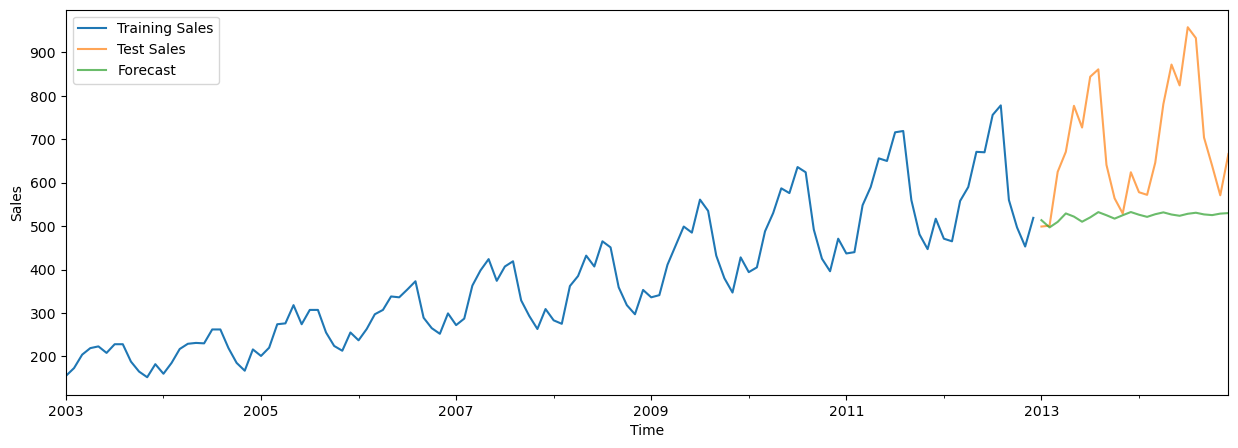

In [50]:
axis = train['Number_Trucks_Sold'].plot(label = 'Training Sales', figsize = (15,5))
test_copy['Number_Trucks_Sold'].plot(ax=axis, label='Test Sales', alpha=0.7)
test_copy['arima_forecast'].plot(ax=axis, label = 'Forecast', alpha=0.7)

axis.set_xlabel('Time')
axis.set_ylabel('Sales')
plt.legend(loc='best')
plt.show()
plt.close()

In [51]:
results_3 = pd.DataFrame({'RMSE': arima_rmse}, index= ['Best ARIMA model: (3,1,3)'])
pd.concat([results_1, results_2, results_3])

,RMSE
"Best AR model: (1,0,0)",306.142152
"Best ARMA model: (3,0,3)",232.039027
"Best ARIMA model: (3,1,3)",212.592157


#### SARIMA

<Figure size 1500x400 with 0 Axes>

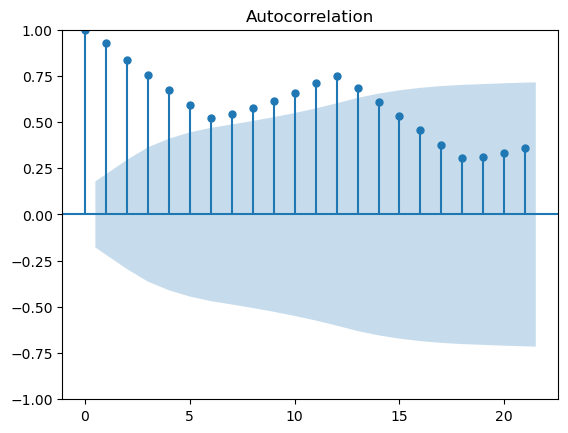

In [52]:

plt.figure(figsize=(15,4))
plot_acf(train['Number_Trucks_Sold'], alpha = 0.05);

In [53]:
sarima_aic = pd.DataFrame(columns =['param', 'seasonal', 'aic'])
sarima_aic

,param,seasonal,aic


In [54]:
for param_seasonal in pdq_seasonal:
    for param in pdq:
        sarima_model= sm.tsa.statespace.SARIMAX(train_log, order = param, seasonal_order= param_seasonal, enforce_stationarity = False, enforce_invertibility = False)
        sarima_results = sarima_model.fit(max_iter = 1000)
        print("SARIMAX{}x{} - AIC{}".format(param,param_seasonal, sarima_results.aic))
        row = {'param': param, 'seasonal': param_seasonal, 'aic':sarima_results.aic}
        sarima_aic = pd.concat([sarima_aic, pd.DataFrame([row])], ignore_index=True)




C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 1)x(1, 0, 1, 12) - AIC-559.2780497704094


C:\Users\austi\AppData\Local\Temp\ipykernel_11840\14470267.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sarima_aic = pd.concat([sarima_aic, pd.DataFrame([row])], ignore_index=True)
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 2)x(1, 0, 1, 12) - AIC-550.9708200913982


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(1, 0, 3)x(1, 0, 1, 12) - AIC-545.6899895110213
SARIMAX(1, 1, 1)x(1, 0, 1, 12) - AIC-551.1530791113072


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(1, 1, 2)x(1, 0, 1, 12) - AIC-544.2255887168003
SARIMAX(1, 1, 3)x(1, 0, 1, 12) - AIC-538.5883531386934


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 1)x(1, 0, 1, 12) - AIC-557.9428123663644


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(2, 0, 2)x(1, 0, 1, 12) - AIC-549.8078907078358


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 3)x(1, 0, 1, 12) - AIC-499.2766568239002
SARIMAX(2, 1, 1)x(1, 0, 1, 12) - AIC-550.8140751255291


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(2, 1, 2)x(1, 0, 1, 12) - AIC-538.5271778890876
SARIMAX(2, 1, 3)x(1, 0, 1, 12) - AIC-536.1126396254507


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 1)x(1, 0, 1, 12) - AIC-549.6715709942412


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(3, 0, 2)x(1, 0, 1, 12) - AIC-548.2245740059985


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 3)x(1, 0, 1, 12) - AIC-258.19624408387574
SARIMAX(3, 1, 1)x(1, 0, 1, 12) - AIC-543.3991344555336


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(3, 1, 2)x(1, 0, 1, 12) - AIC-493.14949379783366


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 3)x(1, 0, 1, 12) - AIC-534.886668554827


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 1)x(1, 0, 2, 12) - AIC-488.8585707992702


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 2)x(1, 0, 2, 12) - AIC-451.7050926409135


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 3)x(1, 0, 2, 12) - AIC-461.26641020394754
SARIMAX(1, 1, 1)x(1, 0, 2, 12) - AIC-482.1327721493848


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(1, 1, 2)x(1, 0, 2, 12) - AIC-475.604837263391


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 3)x(1, 0, 2, 12) - AIC-477.06813517075074


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 1)x(1, 0, 2, 12) - AIC-480.5536662559584


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 2)x(1, 0, 2, 12) - AIC-454.7615993904971


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 3)x(1, 0, 2, 12) - AIC-270.1811821617198


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 1)x(1, 0, 2, 12) - AIC-481.1141912775164


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 2)x(1, 0, 2, 12) - AIC-473.3644589065368


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 3)x(1, 0, 2, 12) - AIC-473.69601039253337


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 1)x(1, 0, 2, 12) - AIC-485.99884336660875


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 2)x(1, 0, 2, 12) - AIC-441.3076274565868


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 3)x(1, 0, 2, 12) - AIC-81.17911858248024


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 1)x(1, 0, 2, 12) - AIC-481.4513103217615


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 2)x(1, 0, 2, 12) - AIC-201.1675567932014


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 3)x(1, 0, 2, 12) - AIC-477.4738281185359


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 1)x(1, 0, 3, 12) - AIC2322.118644197992


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 2)x(1, 0, 3, 12) - AIC2528.5917354751214


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 3)x(1, 0, 3, 12) - AIC2264.4525837210876


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 1)x(1, 0, 3, 12) - AIC2653.368660047139


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 2)x(1, 0, 3, 12) - AIC173.28516935914882
SARIMAX(1, 1, 3)x(1, 0, 3, 12) - AIC2701.7147950238605


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(2, 0, 1)x(1, 0, 3, 12) - AIC2282.9025387995366
SARIMAX(2, 0, 2)x(1, 0, 3, 12) - AIC2489.6439514820363
SARIMAX(2, 0, 3)x(1, 0, 3, 12) - AIC20.0


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge

SARIMAX(2, 1, 1)x(1, 0, 3, 12) - AIC1962.8753691424652


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 2)x(1, 0, 3, 12) - AIC18.0


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 3)x(1, 0, 3, 12) - AIC2406.8663920580348


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 1)x(1, 0, 3, 12) - AIC2284.9021354281476
SARIMAX(3, 0, 2)x(1, 0, 3, 12) - AIC2489.633720945637


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(3, 0, 3)x(1, 0, 3, 12) - AIC22.0


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 1)x(1, 0, 3, 12) - AIC2759.267728503071


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 2)x(1, 0, 3, 12) - AIC20.0


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 3)x(1, 0, 3, 12) - AIC1038.8390292211423


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 1)x(1, 1, 1, 12) - AIC-493.8785680558211


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 2)x(1, 1, 1, 12) - AIC-486.6989674033552


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 3)x(1, 1, 1, 12) - AIC-483.0458740010858


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 1)x(1, 1, 1, 12) - AIC-487.02095558653775


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 2)x(1, 1, 1, 12) - AIC-483.33101486373596


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 3)x(1, 1, 1, 12) - AIC-482.87034855260356


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 1)x(1, 1, 1, 12) - AIC-491.40581600386713


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 2)x(1, 1, 1, 12) - AIC-485.41329293091064


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 3)x(1, 1, 1, 12) - AIC-480.78029640498227
SARIMAX(2, 1, 1)x(1, 1, 1, 12) - AIC192.26465766352715


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(2, 1, 2)x(1, 1, 1, 12) - AIC-484.20254318125075


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 3)x(1, 1, 1, 12) - AIC-484.25039971639984


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 1)x(1, 1, 1, 12) - AIC-482.7648005178502


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 2)x(1, 1, 1, 12) - AIC-481.2857713112946


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 3)x(1, 1, 1, 12) - AIC-481.331599034638


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 1)x(1, 1, 1, 12) - AIC-479.468665129635


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 2)x(1, 1, 1, 12) - AIC-481.74403779946323


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 3)x(1, 1, 1, 12) - AIC-482.3456011084192


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 1)x(1, 1, 2, 12) - AIC-436.45368187430216


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 2)x(1, 1, 2, 12) - AIC-426.22795585980657


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 3)x(1, 1, 2, 12) - AIC-417.9968974165545


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 1)x(1, 1, 2, 12) - AIC-438.40863264071885


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 2)x(1, 1, 2, 12) - AIC-430.3118605988358


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 3)x(1, 1, 2, 12) - AIC-424.5358405178321


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 1)x(1, 1, 2, 12) - AIC-425.1854930988625


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 2)x(1, 1, 2, 12) - AIC-425.5965473529629


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 3)x(1, 1, 2, 12) - AIC-411.28618556283675


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 1)x(1, 1, 2, 12) - AIC155.7392562273622


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 2)x(1, 1, 2, 12) - AIC-428.9290921130598


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 3)x(1, 1, 2, 12) - AIC-426.6815167261576


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 1)x(1, 1, 2, 12) - AIC-425.1387979686296


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 2)x(1, 1, 2, 12) - AIC-416.8934138025795


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 3)x(1, 1, 2, 12) - AIC-407.0739799008956


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 1)x(1, 1, 2, 12) - AIC-435.97273509319444


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 2)x(1, 1, 2, 12) - AIC-433.3119758563731


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 3)x(1, 1, 2, 12) - AIC-427.1521105833578
SARIMAX(1, 0, 1)x(1, 1, 3, 12) - AIC-361.9389603076595


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodel

SARIMAX(1, 0, 2)x(1, 1, 3, 12) - AIC-377.48275260404506
SARIMAX(1, 0, 3)x(1, 1, 3, 12) - AIC-375.8236191359215


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodel

SARIMAX(1, 1, 1)x(1, 1, 3, 12) - AIC-379.73842655446776
SARIMAX(1, 1, 2)x(1, 1, 3, 12) - AIC-375.26781111252114


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodel

SARIMAX(1, 1, 3)x(1, 1, 3, 12) - AIC-367.75719910956917


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 1)x(1, 1, 3, 12) - AIC-379.6741175376225
SARIMAX(2, 0, 2)x(1, 1, 3, 12) - AIC-375.6825615994726


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodel

SARIMAX(2, 0, 3)x(1, 1, 3, 12) - AIC-373.75889211127


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 1)x(1, 1, 3, 12) - AIC129.3459139977314


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 2)x(1, 1, 3, 12) - AIC-372.96578601415024


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 3)x(1, 1, 3, 12) - AIC-368.2289209623786


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 1)x(1, 1, 3, 12) - AIC-378.00720796853534


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 2)x(1, 1, 3, 12) - AIC-373.50084908424367


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 3)x(1, 1, 3, 12) - AIC-372.60013354575506


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 1)x(1, 1, 3, 12) - AIC-376.1013680552947


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 2)x(1, 1, 3, 12) - AIC-373.8890014563636


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 3)x(1, 1, 3, 12) - AIC-367.3656868605035


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 1)x(2, 0, 1, 12) - AIC-497.46840436490726


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 2)x(2, 0, 1, 12) - AIC-495.2762026207551


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 3)x(2, 0, 1, 12) - AIC-496.9231693085611


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 1)x(2, 0, 1, 12) - AIC-490.10211609278707


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 2)x(2, 0, 1, 12) - AIC-486.1180536144137


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 3)x(2, 0, 1, 12) - AIC-489.13386622522444


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 1)x(2, 0, 1, 12) - AIC-490.1710188061374


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 2)x(2, 0, 1, 12) - AIC-485.6456963046394


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 3)x(2, 0, 1, 12) - AIC-314.1668083049876


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 1)x(2, 0, 1, 12) - AIC-481.67521792010024


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 2)x(2, 0, 1, 12) - AIC-481.54309329963917


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 3)x(2, 0, 1, 12) - AIC-480.7054003873885


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 1)x(2, 0, 1, 12) - AIC-482.50337879341595


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 2)x(2, 0, 1, 12) - AIC-477.1970305338253


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 3)x(2, 0, 1, 12) - AIC-154.4487932607686


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 1)x(2, 0, 1, 12) - AIC-479.7997287975002


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 2)x(2, 0, 1, 12) - AIC11.310735547712616


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 3)x(2, 0, 1, 12) - AIC-472.88213233279924


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 1)x(2, 0, 2, 12) - AIC-500.4913597793675


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 2)x(2, 0, 2, 12) - AIC-496.18839121993756


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 3)x(2, 0, 2, 12) - AIC-490.7180815911648


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 1)x(2, 0, 2, 12) - AIC-493.6960105801613


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 2)x(2, 0, 2, 12) - AIC-490.2787200371602


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 3)x(2, 0, 2, 12) - AIC-490.65120914452547


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 1)x(2, 0, 2, 12) - AIC-499.0254857106288


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 2)x(2, 0, 2, 12) - AIC-494.3105353715357


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 3)x(2, 0, 2, 12) - AIC-362.137896552031


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 1)x(2, 0, 2, 12) - AIC-485.25812298079256


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 2)x(2, 0, 2, 12) - AIC-476.0184141415534


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 3)x(2, 0, 2, 12) - AIC-487.3426254014363


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 1)x(2, 0, 2, 12) - AIC-492.8596259499979


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 2)x(2, 0, 2, 12) - AIC-484.7026222683244


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 3)x(2, 0, 2, 12) - AIC-119.49683325317423


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 1)x(2, 0, 2, 12) - AIC-485.2684676429173


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 2)x(2, 0, 2, 12) - AIC50.797320026113375


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 3)x(2, 0, 2, 12) - AIC-477.29050439188825


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 1)x(2, 0, 3, 12) - AIC2061.1688271530393
SARIMAX(1, 0, 2)x(2, 0, 3, 12) - AIC2270.8469969762405


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(1, 0, 3)x(2, 0, 3, 12) - AIC2009.9169434150601


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 1)x(2, 0, 3, 12) - AIC2230.3093213758766


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 2)x(2, 0, 3, 12) - AIC2317.072012095997
SARIMAX(1, 1, 3)x(2, 0, 3, 12) - AIC2289.1500354553987


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(2, 0, 1)x(2, 0, 3, 12) - AIC2021.9533653766666


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 2)x(2, 0, 3, 12) - AIC2231.8993787321224


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 3)x(2, 0, 3, 12) - AIC22.0


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 1)x(2, 0, 3, 12) - AIC2338.673879527687


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 2)x(2, 0, 3, 12) - AIC2443.1799681760795


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 3)x(2, 0, 3, 12) - AIC1994.3101241092209


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 1)x(2, 0, 3, 12) - AIC2023.9545097642847


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 2)x(2, 0, 3, 12) - AIC2231.890295215928


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 3)x(2, 0, 3, 12) - AIC2587.7834979888503


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 1)x(2, 0, 3, 12) - AIC2336.207603842794
SARIMAX(3, 1, 2)x(2, 0, 3, 12) - AIC22.0


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(3, 1, 3)x(2, 0, 3, 12) - AIC620.0473984241584


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 1)x(2, 1, 1, 12) - AIC-442.82653795000533


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 2)x(2, 1, 1, 12) - AIC-440.9532032951968


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 3)x(2, 1, 1, 12) - AIC-442.8812975898083


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 1)x(2, 1, 1, 12) - AIC-437.49812593793456
SARIMAX(1, 1, 2)x(2, 1, 1, 12) - AIC-436.0484254720484


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 3)x(2, 1, 1, 12) - AIC-435.0616059107489


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(2, 0, 1)x(2, 1, 1, 12) - AIC-434.0291387676816


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 2)x(2, 1, 1, 12) - AIC-432.6924197057127


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 3)x(2, 1, 1, 12) - AIC-434.12219216624464


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 1)x(2, 1, 1, 12) - AIC164.07628455475654


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 2)x(2, 1, 1, 12) - AIC-431.12493010581886


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 3)x(2, 1, 1, 12) - AIC-448.2124432805822


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 1)x(2, 1, 1, 12) - AIC-430.88690637155247
SARIMAX(3, 0, 2)x(2, 1, 1, 12) - AIC-431.56444826268586


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(3, 0, 3)x(2, 1, 1, 12) - AIC-430.26227904394017


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 1)x(2, 1, 1, 12) - AIC-426.3109172205483


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 2)x(2, 1, 1, 12) - AIC-444.0305259282021


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 3)x(2, 1, 1, 12) - AIC-435.6518128525508
SARIMAX(1, 0, 1)x(2, 1, 2, 12) - AIC-427.11810412666796


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(1, 0, 2)x(2, 1, 2, 12) - AIC-423.42624999057455


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 3)x(2, 1, 2, 12) - AIC-419.06886628492254


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 1)x(2, 1, 2, 12) - AIC-435.28401951070424


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 2)x(2, 1, 2, 12) - AIC-426.8766928660475


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 3)x(2, 1, 2, 12) - AIC-418.11397438701533


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 1)x(2, 1, 2, 12) - AIC-426.28930262771667


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 2)x(2, 1, 2, 12) - AIC-422.11377890047385
SARIMAX(2, 0, 3)x(2, 1, 2, 12) - AIC-416.35042466290344


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 1)x(2, 1, 2, 12) - AIC164.39368521484755


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(2, 1, 2)x(2, 1, 2, 12) - AIC-423.30827392700894


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 3)x(2, 1, 2, 12) - AIC-423.40596382620413


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 1)x(2, 1, 2, 12) - AIC-421.8188635977919


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 2)x(2, 1, 2, 12) - AIC-415.8340136268124
SARIMAX(3, 0, 3)x(2, 1, 2, 12) - AIC-409.92392001726785


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(3, 1, 1)x(2, 1, 2, 12) - AIC-423.5706252029644


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 2)x(2, 1, 2, 12) - AIC-438.130866500951


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 3)x(2, 1, 2, 12) - AIC-429.4725090882698


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 1)x(2, 1, 3, 12) - AIC-380.4695545731182
SARIMAX(1, 0, 2)x(2, 1, 3, 12) - AIC-376.27803969362077


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 3)x(2, 1, 3, 12) - AIC-374.3557484751305


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodel

SARIMAX(1, 1, 1)x(2, 1, 3, 12) - AIC-377.20724049967913
SARIMAX(1, 1, 2)x(2, 1, 3, 12) - AIC-373.3626061764792


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodel

SARIMAX(1, 1, 3)x(2, 1, 3, 12) - AIC-365.656467843222


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 1)x(2, 1, 3, 12) - AIC-377.18037308535145


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 2)x(2, 1, 3, 12) - AIC-374.7654365272327


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 3)x(2, 1, 3, 12) - AIC-372.29034486713095


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 1)x(2, 1, 3, 12) - AIC129.60775633943598


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 2)x(2, 1, 3, 12) - AIC-371.2693693991696


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 3)x(2, 1, 3, 12) - AIC-366.9975870941353


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 1)x(2, 1, 3, 12) - AIC-375.0308416040954


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 2)x(2, 1, 3, 12) - AIC-374.0428999050355


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(3, 0, 3)x(2, 1, 3, 12) - AIC-370.7779187352104


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 1)x(2, 1, 3, 12) - AIC-373.1804371162984


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodel

SARIMAX(3, 1, 2)x(2, 1, 3, 12) - AIC-371.7140096373785


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 3)x(2, 1, 3, 12) - AIC-365.52857630188674


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 1)x(3, 0, 1, 12) - AIC-442.73508944594926


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 2)x(3, 0, 1, 12) - AIC-440.8234286841601


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 3)x(3, 0, 1, 12) - AIC-441.3391541517493


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 1)x(3, 0, 1, 12) - AIC-436.46651238698394


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 2)x(3, 0, 1, 12) - AIC-432.8247089152968


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 3)x(3, 0, 1, 12) - AIC-433.06908439504514


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 1)x(3, 0, 1, 12) - AIC-435.0254435770086


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 2)x(3, 0, 1, 12) - AIC-430.4366943819295


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 3)x(3, 0, 1, 12) - AIC-211.42920558462086
SARIMAX(2, 1, 1)x(3, 0, 1, 12) - AIC-425.2904283758797


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(2, 1, 2)x(3, 0, 1, 12) - AIC-427.9001954593323


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 3)x(3, 0, 1, 12) - AIC-427.083446158692


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 1)x(3, 0, 1, 12) - AIC-429.39626776578945


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 2)x(3, 0, 1, 12) - AIC-421.1148851151006


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 3)x(3, 0, 1, 12) - AIC-197.88310898926457


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 1)x(3, 0, 1, 12) - AIC-424.4681243101787


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 2)x(3, 0, 1, 12) - AIC31.714438488782733


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 3)x(3, 0, 1, 12) - AIC-419.1389019664382


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 1)x(3, 0, 2, 12) - AIC-443.9236525469948


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 2)x(3, 0, 2, 12) - AIC-442.03357317530504


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 3)x(3, 0, 2, 12) - AIC-441.3340677349594


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 1)x(3, 0, 2, 12) - AIC-435.66568496874424


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 2)x(3, 0, 2, 12) - AIC-431.53469344247446


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 3)x(3, 0, 2, 12) - AIC-434.3810053228394


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 1)x(3, 0, 2, 12) - AIC-435.6129923120674


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 2)x(3, 0, 2, 12) - AIC-432.11877845844845


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 3)x(3, 0, 2, 12) - AIC-122.90868402251107


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 1)x(3, 0, 2, 12) - AIC-426.11064847374234


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 2)x(3, 0, 2, 12) - AIC-427.9795908643487
SARIMAX(2, 1, 3)x(3, 0, 2, 12) - AIC-429.6231692201149


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(3, 0, 1)x(3, 0, 2, 12) - AIC-430.1695264479732


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 2)x(3, 0, 2, 12) - AIC-424.9311633563037


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 3)x(3, 0, 2, 12) - AIC-196.77732651083352


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 1)x(3, 0, 2, 12) - AIC-423.91663242808687
SARIMAX(3, 1, 2)x(3, 0, 2, 12) - AIC51.61439709240106


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(3, 1, 3)x(3, 0, 2, 12) - AIC-419.85201912743617


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 1)x(3, 0, 3, 12) - AIC2256.941024206756


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 2)x(3, 0, 3, 12) - AIC2464.260283351224


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 3)x(3, 0, 3, 12) - AIC2200.96065738995


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 1)x(3, 0, 3, 12) - AIC2388.02223846351


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 2)x(3, 0, 3, 12) - AIC671.9288370703442
SARIMAX(1, 1, 3)x(3, 0, 3, 12) - AIC2443.018637736885


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(2, 0, 1)x(3, 0, 3, 12) - AIC2217.7217767745074


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 2)x(3, 0, 3, 12) - AIC2425.3128560733576


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 3)x(3, 0, 3, 12) - AIC24.0


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 1)x(3, 0, 3, 12) - AIC1451.7926125191007
SARIMAX(2, 1, 2)x(3, 0, 3, 12) - AIC22.0


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(2, 1, 3)x(3, 0, 3, 12) - AIC2148.171688018604


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 1)x(3, 0, 3, 12) - AIC2192.9213567858233
SARIMAX(3, 0, 2)x(3, 0, 3, 12) - AIC2425.303758922479


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(3, 0, 3)x(3, 0, 3, 12) - AIC26.0


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 1)x(3, 0, 3, 12) - AIC2463.4034739717454


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 2)x(3, 0, 3, 12) - AIC24.0


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 3)x(3, 0, 3, 12) - AIC657.3173736586215


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 1)x(3, 1, 1, 12) - AIC-389.2621029399546


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 2)x(3, 1, 1, 12) - AIC-394.16761092112085


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 3)x(3, 1, 1, 12) - AIC-394.66276247663336
SARIMAX(1, 1, 1)x(3, 1, 1, 12) - AIC-391.2519498175834


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(1, 1, 2)x(3, 1, 1, 12) - AIC-389.5091434672651


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 3)x(3, 1, 1, 12) - AIC-388.15850795997676


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 1)x(3, 1, 1, 12) - AIC-390.2784787573173


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 2)x(3, 1, 1, 12) - AIC-388.64388800816397


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 3)x(3, 1, 1, 12) - AIC-384.5346711638463
SARIMAX(2, 1, 1)x(3, 1, 1, 12) - AIC125.0901060126421


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments

SARIMAX(2, 1, 2)x(3, 1, 1, 12) - AIC-381.6926283368194


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 3)x(3, 1, 1, 12) - AIC-390.06719529528885


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 1)x(3, 1, 1, 12) - AIC-378.1514776427279


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 2)x(3, 1, 1, 12) - AIC-372.7188321334875


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 3)x(3, 1, 1, 12) - AIC-378.36237286043405


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 1)x(3, 1, 1, 12) - AIC-379.9908029574882


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 2)x(3, 1, 1, 12) - AIC-395.09452797837594


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 3)x(3, 1, 1, 12) - AIC-394.50617422964746


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 1)x(3, 1, 2, 12) - AIC-369.69241068152087


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 2)x(3, 1, 2, 12) - AIC-362.9988111056199


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 3)x(3, 1, 2, 12) - AIC-364.543769368887


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 1)x(3, 1, 2, 12) - AIC-390.2103634603543


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 2)x(3, 1, 2, 12) - AIC-389.5746820302905


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 3)x(3, 1, 2, 12) - AIC-389.01861786251584


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 1)x(3, 1, 2, 12) - AIC-371.3728130666818


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 2)x(3, 1, 2, 12) - AIC-356.5600706299687


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 3)x(3, 1, 2, 12) - AIC-357.88854296298626


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 1)x(3, 1, 2, 12) - AIC125.49131169774623


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 2)x(3, 1, 2, 12) - AIC-381.1266206703091


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 3)x(3, 1, 2, 12) - AIC-378.3840520113052


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 1)x(3, 1, 2, 12) - AIC-361.9681678079454


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 2)x(3, 1, 2, 12) - AIC-367.5095079948942


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 3)x(3, 1, 2, 12) - AIC-369.67728332481676


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 1)x(3, 1, 2, 12) - AIC-378.4036263345954


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 2)x(3, 1, 2, 12) - AIC-383.4945201016705
SARIMAX(3, 1, 3)x(3, 1, 2, 12) - AIC-370.033043658735


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodel

SARIMAX(1, 0, 1)x(3, 1, 3, 12) - AIC-383.4917339710071


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 2)x(3, 1, 3, 12) - AIC-380.4053982123036


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 0, 3)x(3, 1, 3, 12) - AIC-358.166098170248


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 1)x(3, 1, 3, 12) - AIC-380.21206528471447


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 2)x(3, 1, 3, 12) - AIC-376.5834680881386


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(1, 1, 3)x(3, 1, 3, 12) - AIC-368.7903370908052


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 1)x(3, 1, 3, 12) - AIC-384.05995612552965


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 2)x(3, 1, 3, 12) - AIC-379.20331817747586


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 0, 3)x(3, 1, 3, 12) - AIC-374.26588384266773


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 1)x(3, 1, 3, 12) - AIC134.1208826085522


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 2)x(3, 1, 3, 12) - AIC-373.1442863985663


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(2, 1, 3)x(3, 1, 3, 12) - AIC-368.0456696246821
SARIMAX(3, 0, 1)x(3, 1, 3, 12) - AIC-352.6034139538923


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 0, 2)x(3, 1, 3, 12) - AIC-366.5301205915782


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodel

SARIMAX(3, 0, 3)x(3, 1, 3, 12) - AIC-374.19061513749415


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 1)x(3, 1, 3, 12) - AIC-373.46545282501444


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


SARIMAX(3, 1, 2)x(3, 1, 3, 12) - AIC-389.04993909788544
SARIMAX(3, 1, 3)x(3, 1, 3, 12) - AIC-384.3286941764191


C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [55]:
sarima_aic.sort_values(by=['aic']).head()

,param,seasonal,aic
0,"(1, 0, 1)","(1, 0, 1, 12)",-559.278050
6,"(2, 0, 1)","(1, 0, 1, 12)",-557.942812
3,"(1, 1, 1)","(1, 0, 1, 12)",-551.153079
1,"(1, 0, 2)","(1, 0, 1, 12)",-550.970820
9,"(2, 1, 1)","(1, 0, 1, 12)",-550.814075


In [56]:
best_sarima = sm.tsa.statespace.SARIMAX(train_log, order = (1,0,1), seasonal_order = (1,0,1,12), enforce_stationarity=True)
best_sarima_results = best_sarima.fit()

print(best_sarima_results.summary().tables[0])
print(best_sarima_results.summary().tables[1])

C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\austi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


                                     SARIMAX Results                                      
Dep. Variable:                 Number_Trucks_Sold   No. Observations:                  120
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 302.280
Date:                            Wed, 11 Jun 2025   AIC                           -594.559
Time:                                    18:05:56   BIC                           -580.622
Sample:                                01-01-2003   HQIC                          -588.899
                                     - 12-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9956      0.006    159.205      0.000       0.983       1.008
ma.L1         -0.2952      0.084   

In [57]:
sarima_pred_dynamic = best_sarima_results.get_prediction(start = pd.to_datetime('2012-01-01'), dynamic= True)
sarima_pred_99 = best_sarima_results.get_forecast(steps = len(test))

test_copy['sarima_forecast'] = np.power(10, sarima_pred_99.predicted_mean)

sarima_mse = ((test_copy['Number_Trucks_Sold'] - test_copy['sarima_forecast']) **2).mean()
sarima_rmse = np.sqrt(sarima_mse)

print('The Root Mean Squared Error of our forecasts is {}'.format(round(sarima_rmse, 3)))

The Root Mean Squared Error of our forecasts is 84.268


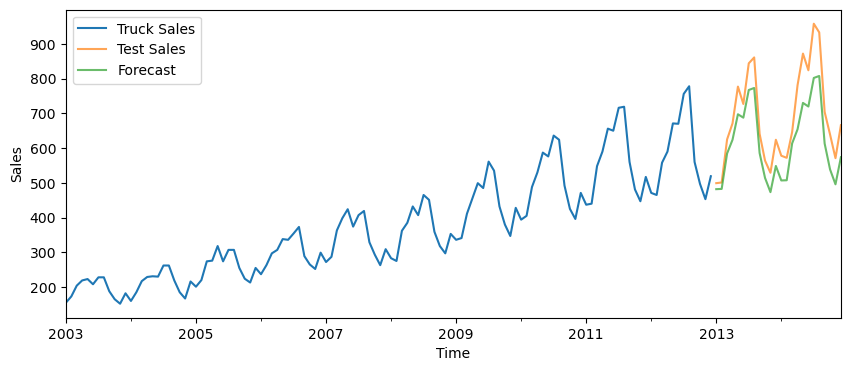

In [58]:
axis = train['Number_Trucks_Sold'].plot(label='Truck Sales', figsize = (10,4))
test_copy['Number_Trucks_Sold'].plot(ax=axis, label = 'Test Sales', alpha = 0.7)
test_copy['sarima_forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.set_xlabel('Time')
axis.set_ylabel('Sales')
plt.legend(loc='best')
plt.show()

In [59]:
results_4 = pd.DataFrame({'RMSE': sarima_rmse}, index= ['Best SARIMA model: (1,0,1) x (1,0,1,12)'])
pd.concat([results_1,results_2,results_3, results_4])

,RMSE
"Best AR model: (1,0,0)",306.142152
"Best ARMA model: (3,0,3)",232.039027
"Best ARIMA model: (3,1,3)",212.592157
"Best SARIMA model: (1,0,1) x (1,0,1,12)",84.268220


#### Exponential Smoothing

In [60]:
ex_smooth_add = ExponentialSmoothing(train_log, seasonal_periods = 12, trend='add', seasonal = 'add', damped_trend = True, use_boxcox = True, initialization_method = 'estimated').fit()

ex_smooth_mul = ExponentialSmoothing(train_log, seasonal_periods = 12, trend='mul', seasonal = 'add', damped_trend = True, use_boxcox = True, initialization_method = 'estimated').fit()

test_copy['Exponential Smoothing Additive Model']= np.power(10, ex_smooth_add.forecast(len(test)))

test_copy['Exponential Smoothing Multiplicitive Model']= np.power(10, ex_smooth_mul.forecast(len(test)))


add_mse = ((test_copy['Number_Trucks_Sold'] - test_copy['Exponential Smoothing Additive Model']) **2).mean()
add_rmse = np.sqrt(add_mse)

mul_mse = ((test_copy['Number_Trucks_Sold'] - test_copy['Exponential Smoothing Multiplicitive Model']) **2).mean()
mul_rmse = np.sqrt(mul_mse)

print('The Root Mean Squared Error of the smoothing forecasts are {} & {}'.format(round(add_rmse, 3), round(mul_rmse,3)))

The Root Mean Squared Error of the smoothing forecasts are 43.4 & 209.025


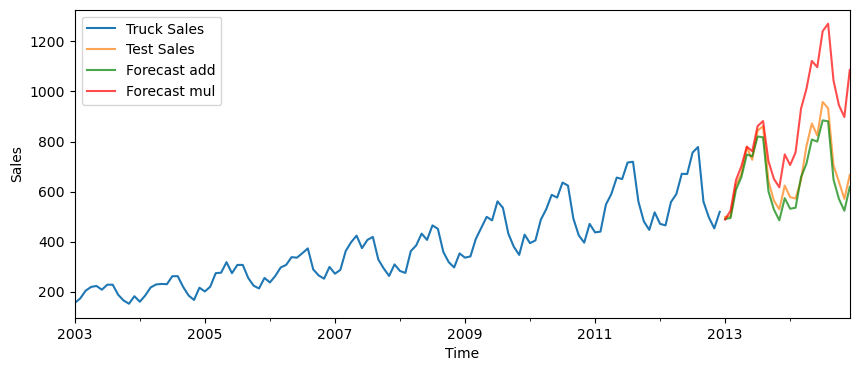

In [61]:
axis = train['Number_Trucks_Sold'].plot(label='Truck Sales', figsize = (10,4))
test_copy['Number_Trucks_Sold'].plot(ax=axis, label = 'Test Sales', alpha = 0.7)
test_copy['Exponential Smoothing Additive Model'].plot(ax=axis, label='Forecast add', alpha=0.7, color = 'green')
test_copy['Exponential Smoothing Multiplicitive Model'].plot(ax=axis, label='Forecast mul', alpha=0.7, color = 'red')
axis.set_xlabel('Time')
axis.set_ylabel('Sales')
plt.legend(loc='best')
plt.show()

In [62]:
results_5 = pd.DataFrame({'RMSE': add_rmse}, index = ["Best Exponential Smoothing Model: Holt's Winter Seasonal"])

pd.concat([results_1, results_2, results_3, results_4, results_5])

,RMSE
"Best AR model: (1,0,0)",306.142152
"Best ARMA model: (3,0,3)",232.039027
"Best ARIMA model: (3,1,3)",212.592157
"Best SARIMA model: (1,0,1) x (1,0,1,12)",84.268220
Best Exponential Smoothing Model: Holt's Winter Seasonal,43.399955


### Creating Forecasts with best Model

In [63]:
best_model = ExponentialSmoothing(df['Number_Trucks_Sold'], seasonal_periods = 12, trend='add', seasonal = 'add', damped_trend = True, use_boxcox = True, initialization_method = 'estimated').fit()

best_ex_smooth_forecast = best_model.forecast(60)
best_ex_smooth_interval = best_model.simulate(60, anchor = len(df)-1, repetitions= 50,error='add')

[]

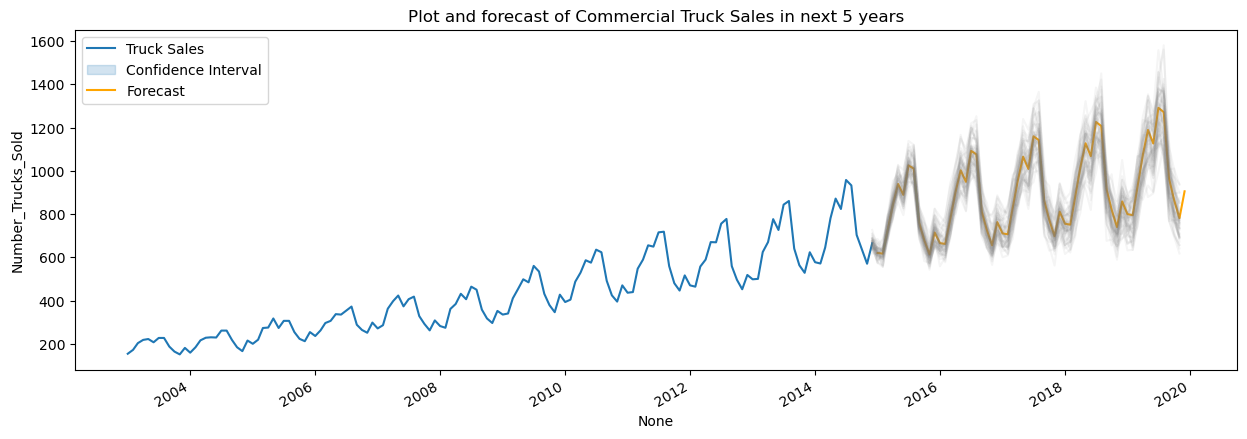

In [64]:
plt.figure(figsize = (15,5))
axis = sns.lineplot(data= df, x=df.index, y='Number_Trucks_Sold')
best_ex_smooth_forecast.plot(ax=axis, color = 'orange', label = 'Forecast')
best_ex_smooth_interval.plot(ax=axis, alpha = 0.08, label= 'Confidence Interval', color = 'grey')
plt.legend(['Truck Sales', 'Confidence Interval', 'Forecast'],loc='best')
plt.title('Plot and forecast of Commercial Truck Sales in next 5 years')
axis.plot()

In [67]:
print((905.7 / 666) - 1)
print('The commercial truck sales are projected to go up another 36% over the next 5 years')

0.3599099099099099
The commercial truck sales are projected to go up another 36% over the next 5 years


## Conclusions 

Some of the main insights that were found are as followed: 
* Some of the best preforming months are during the Summer (May - August)
* Commercial Truck sales are trending up year after year, with a 36% increase over the next 5 years projected

Total Commercial Truck Sales will be grow as follows through the 5 year forecast: 
- 2015: 9443 units 
- 2016: 10087 units
- 2017: 10728 units
- 2018: 11364 units 
- 2019: 11992 units